![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Sentiment Analysis </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainSentimentAnalysis.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/11_RNN/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab      import Vocab
from torchtext.datasets   import IMDB

### Embedding layer:
Replace the integers $\left\{ 0,1,\dots,9\right\} $ by vectors in $\mathbb{R}^{5}$

In [5]:
oEmbedding = nn.Embedding(num_embeddings=10, embedding_dim=5)
v          = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
oEmbedding(v)

tensor([[-0.8166, -0.5618,  0.8159,  0.9349, -1.5100],
        [-0.4890, -0.3902,  1.1656, -1.5701,  0.5593],
        [-0.2523,  0.6294, -2.0510, -1.4809, -0.5413],
        [-0.0840, -0.0102,  0.2787,  0.2616, -1.1439],
        [ 1.1258,  0.3329, -1.1959,  0.2383, -0.4934],
        [ 1.5391,  1.3446,  0.9179, -0.1970, -0.8255],
        [-2.0919, -0.9831, -0.7881,  0.8321, -2.6629],
        [-1.6773, -1.4274,  0.7915,  0.1021,  0.3497],
        [ 0.2773, -0.6689, -0.3759,  0.3203,  1.7878],
        [ 0.3740, -1.5495, -1.0190, -0.6252, -1.0143]],
       grad_fn=<EmbeddingBackward0>)

### Get the IMDB dataset:

In [6]:
dirPath             = '../../data'
oTokenizer          = get_tokenizer('basic_english')

trainIter, testIter = IMDB(root=dirPath)

lFullTrainSet = list(trainIter)
lFullTestSet  = list(testIter)

#### Filter long sequences:
Keep only sequences with less than `maxLength` words

In [7]:
def NumWords(line):
    return len(line.split())

maxLength = 100
lTrainSet = [(label, line) for (label, line) in lFullTrainSet if NumWords(line) < maxLength]
lTestSet  = [(label, line) for (label, line) in lFullTestSet  if NumWords(line) < maxLength]

In [8]:
len(lFullTrainSet), len(lFullTestSet), len(lTrainSet), len(lTestSet)

(25000, 25000, 2926, 3091)

#### Show some sentences:

In [9]:
import random

red   = '\x1b[31m'
green = '\x1b[32m'
end   = '\x1b[0m'

for _  in range(3):
    (label, line) = random.choice(lTrainSet)
    
    color = red if label == 'neg' else green
    print('=========================================================================================================')
    print('=========================================================================================================')
    print(color + line + end)
    print('--Tokenizer:---------------------------')    
    print(oTokenizer(line))

Basic meaning of the story is a reality. Cruel true reality. Situations are very funny. You have to laugh when you see, how people can be stupid, obstinate and crazy. The best description will be, if you watch it on your own.
--Tokenizer:---------------------------
['basic', 'meaning', 'of', 'the', 'story', 'is', 'a', 'reality', '.', 'cruel', 'true', 'reality', '.', 'situations', 'are', 'very', 'funny', '.', 'you', 'have', 'to', 'laugh', 'when', 'you', 'see', ',', 'how', 'people', 'can', 'be', 'stupid', ',', 'obstinate', 'and', 'crazy', '.', 'the', 'best', 'description', 'will', 'be', ',', 'if', 'you', 'watch', 'it', 'on', 'your', 'own', '.']
I liked this movie. When the guy who was in on a bank heist of $40 million in gold dies, his cell mate is used as "Bait" to lead them to the high-tech crazy killer partner (by having a monitoring device implanted in his jaw without his knowledge). It's an action, spy type film with enough comical scenes to keep it light. It reminded me of Enemy Of

### Build the vocabulary:
We keep only words that appear more than `min_freq` times.

In [10]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lDataset):
    for (label, line) in lDataset:
        yield oTokenizer(line)

oVocab = build_vocab_from_iterator(YieldTokens(lTrainSet), min_freq=5, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
oVocab.set_default_index(oVocab['<UNK>'])
len(oVocab)

3268

#### Using the vocabulary:

In [11]:
#-- Using [·]:
oVocab['the'], oVocab['a'], oVocab['asfdlkasdjf'], oVocab['aaab'], oVocab['!']

(5, 7, 0, 0, 19)

In [12]:
#-- Using (·):
oVocab(['the', 'a', 'asfdlkasdjf', 'aaab', '!'])

[5, 7, 0, 0, 19]

In [13]:
#-- int to string:
oVocab.get_itos()[4], oVocab.get_itos()[8], oVocab.get_itos()[0], oVocab.get_itos()[19]

('.', 'and', '<UNK>', '!')

#### Text to sequence:

In [14]:
def Text2Tensor(line):
    lLine = ['<SOS>'] + [token for token in oTokenizer(line)] + ['<EOS>']
    return torch.tensor(oVocab(lLine))
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def Label2Int(label):
    if label == 'pos':
        return 1
    else:
        return 0
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
line = 'Hello World!'
print('Input :', line)
print('Output:', Text2Tensor(line))

Input : Hello World!
Output: tensor([   1, 3005,  196,   19,    2])


In [15]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pack_sequence

def Collate(lBatch):
    Nb  = len(lBatch)
    vY  = torch.empty(Nb)
    lX  = [None] * Nb
    for ii, (label, line) in enumerate(lBatch):
        vY[ii] = Label2Int  (label)
        lX[ii] = Text2Tensor(line)
    
    mPackX = pack_sequence(lX, enforce_sorted=False)

    return mPackX, vY

#### Remark
It is better to group lines with similar length together (as in `BucketIterator`).

In [16]:
batchSize = 64
oTrainDL  = DataLoader(lTrainSet, batch_size=1*batchSize, shuffle=True,  collate_fn=Collate)
oTestDL   = DataLoader(lTestSet,  batch_size=2*batchSize, shuffle=False, collate_fn=Collate)

#### Define the RNN model:

In [17]:
from torch.nn.utils.rnn import PackedSequence

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

V = len(oVocab) #-- Vocab size
D = 64          #-- embedding dim
H = 256         #-- RNN hidden dim
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.oEmbedding = nn.Embedding(V, D)
        self.oRNN       = nn.RNN      (D, H, batch_first=True)
        self.oLinear    = nn.Linear   (H, 1)
        
    def forward(self, mPackX):
                                              #-- mPackX.shape = (N*T,)
        mE     = self.oEmbedding(mPackX.data) #-- mE    .shape = (N*T, D)
        mPackE = PackedAs       (mE, mPackX)  #-- mPackE.shape = (N*T, D)
        _, mH = self.oRNN       (mPackE)      #-- mH    .shape = (1, N, H)
        mZ    = self.oLinear    (mH[0])       #-- mZ    .shape = (N, 1)
        return mZ[:,0]

mPackX, vY = next(iter(oTrainDL))
RNN()(mPackX).shape

torch.Size([64])

In [18]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.BCEWithLogitsLoss()

In [19]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Metric   import BinaryAcuuracy
from DeepLearningFramework.Training import TrainModel

nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = RNN       ().to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=5e-6, betas=(0.8, 0.9))
oScheduler = OneCycleLR(oOptim, max_lr=5e-5, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, BinaryAcuuracy, nEpochs, oOptim, oScheduler)

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.695 | Val loss:  0.695 | Train Metric:  0.486 | Val Metric:  0.484 | epoch time:  1.505 | <-- Checkpoint!
Epoch 001: | Train loss:  0.693 | Val loss:  0.693 | Train Metric:  0.505 | Val Metric:  0.504 | epoch time:  0.869 | <-- Checkpoint!
Epoch 002: | Train loss:  0.691 | Val loss:  0.691 | Train Metric:  0.533 | Val Metric:  0.542 | epoch time:  0.881 | <-- Checkpoint!
Epoch 003: | Train loss:  0.689 | Val loss:  0.690 | Train Metric:  0.553 | Val Metric:  0.548 | epoch time:  0.935 | <-- Checkpoint!
Epoch 004: | Train loss:  0.687 | Val loss:  0.689 | Train Metric:  0.552 | Val Metric:  0.543 | epoch time:  0.912 |
Epoch 005: | Train loss:  0.686 | Val loss:  0.688 | Train Metric:  0.555 | Val Metric:  0.544 | epoch time:  0.932 |
Epoch 006: | Train loss:  0.685 | Val loss:  0.687 | Train Metric:  0.555 | Val Metric:  0.543 | epoch time

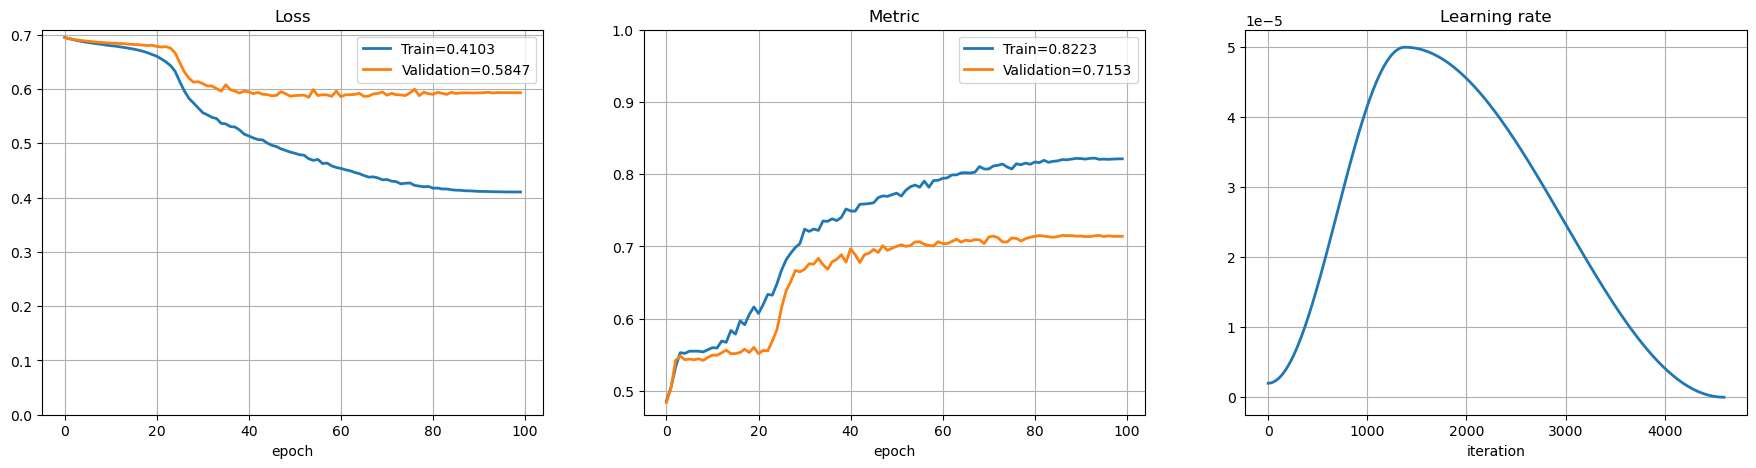

In [20]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()